In [1]:
import sys
sys.path.append("/Users/amartorajaram/Downloads/neural_seq_decoder/scripts")

In [2]:
sessionNames = ['t12.2022.04.28',  't12.2022.05.26',  't12.2022.06.21',  't12.2022.07.21',  't12.2022.08.13',
't12.2022.05.05',  't12.2022.06.02',  't12.2022.06.23',  't12.2022.07.27',  't12.2022.08.18',
't12.2022.05.17',  't12.2022.06.07',  't12.2022.06.28',  't12.2022.07.29',  't12.2022.08.23',
't12.2022.05.19',  't12.2022.06.14',  't12.2022.07.05',  't12.2022.08.02',  't12.2022.08.25',
't12.2022.05.24',  't12.2022.06.16',  't12.2022.07.14',  't12.2022.08.11']
print(len(sessionNames))
sessionNames.sort()

24


In [3]:
import re 
from g2p_en import G2p
import numpy as np

g2p = G2p()
PHONE_DEF = [
    'AA', 'AE', 'AH', 'AO', 'AW',
    'AY', 'B',  'CH', 'D', 'DH',
    'EH', 'ER', 'EY', 'F', 'G',
    'HH', 'IH', 'IY', 'JH', 'K',
    'L', 'M', 'N', 'NG', 'OW',
    'OY', 'P', 'R', 'S', 'SH',
    'T', 'TH', 'UH', 'UW', 'V',
    'W', 'Y', 'Z', 'ZH'
]
PHONE_DEF_SIL = PHONE_DEF + ['SIL']

def phoneToId(p):
    return PHONE_DEF_SIL.index(p)

In [4]:
import scipy

def loadFeaturesAndNormalize(sessionPath):
    
    dat = scipy.io.loadmat(sessionPath)

    input_features = []
    transcriptions = []
    frame_lens = []
    block_means = []
    block_stds = []
    n_trials = dat['sentenceText'].shape[0]

    #collect area 6v tx1 and spikePow features
    for i in range(n_trials):    
        #get time series of TX and spike power for this trial
        #first 128 columns = area 6v only
        features = np.concatenate([dat['tx1'][0,i][:,0:128], dat['spikePow'][0,i][:,0:128]], axis=1)

        sentence_len = features.shape[0]
        sentence = dat['sentenceText'][i].strip()
        input_features.append(features)
        transcriptions.append(sentence)
        frame_lens.append(sentence_len)

    #block-wise feature normalization
    blockNums = np.squeeze(dat['blockIdx'])
    blockList = np.unique(blockNums)
    blocks = []
    for b in range(len(blockList)):
        sentIdx = np.argwhere(blockNums==blockList[b])
        sentIdx = sentIdx[:,0].astype(np.int32)
        blocks.append(sentIdx)

    for b in range(len(blocks)):
        feats = np.concatenate(input_features[blocks[b][0]:(blocks[b][-1]+1)], axis=0)
        feats_mean = np.mean(feats, axis=0, keepdims=True)
        feats_std = np.std(feats, axis=0, keepdims=True)
        for i in blocks[b]:
            input_features[i] = (input_features[i] - feats_mean) / (feats_std + 1e-8)

    #convert to tfRecord file
    session_data = {
        'inputFeatures': input_features,
        'transcriptions': transcriptions,
        'frameLens': frame_lens
    }

    return session_data

In [10]:
import os

def getDataset(fileName):
    print(f"\n📂 Loading file: {fileName}")

    session_data = loadFeaturesAndNormalize(fileName)

    allDat = []
    trueSentences = []
    seqElements = []

    for x in range(len(session_data['inputFeatures'])):
        sentence = str(session_data['transcriptions'][x]).strip()
        print(f"\n🟡 Processing sentence {x}: \"{sentence}\"")

        # Clean and prep text
        thisTranscription = re.sub(r'[^a-zA-Z\- \']', '', sentence)
        thisTranscription = thisTranscription.replace('--', '').lower()

        phonemes = []
        for p in g2p(thisTranscription):
            if p == ' ':
                phonemes.append('SIL')
            p = re.sub(r'[0-9]', '', p)
            if re.match(r'[A-Z]+', p):
                phonemes.append(p)

        if len(phonemes) == 0:
            print(f"⚠️ Skipping — no valid phonemes for: \"{sentence}\"")
            continue

        phonemes.append('SIL')
        print(f"✅ Phonemes: {phonemes}")

        # Create phoneme ID sequence
        try:
            maxSeqLen = 500
            seqLen = len(phonemes)
            seqClassIDs = np.zeros([maxSeqLen], dtype=np.int32)
            seqClassIDs[0:seqLen] = [phoneToId(p) + 1 for p in phonemes]
        except Exception as e:
            print(f"❌ Error converting phonemes to IDs for sentence {x}: {e}")
            continue

        # Add to dataset
        allDat.append(session_data['inputFeatures'][x])
        trueSentences.append(sentence)
        seqElements.append(seqClassIDs)

    print(f"\n✅ Finished processing {len(seqElements)} valid examples")

    newDataset = {
        'sentenceDat': allDat,
        'transcriptions': trueSentences,
        'phonemes': seqElements,
    }

    # Handle lengths
    timeSeriesLens = []
    phoneLens = []

    for x in range(len(newDataset['sentenceDat'])):
        timeSeriesLens.append(newDataset['sentenceDat'][x].shape[0])
        zeroIdx = np.argwhere(newDataset['phonemes'][x] == 0)
        if zeroIdx.size == 0:
            print(f"⚠️ Warning: No padding zeros found in phoneme seq {x}")
            phoneLens.append(len(newDataset['phonemes'][x]))
        else:
            phoneLens.append(zeroIdx[0, 0])

    newDataset['timeSeriesLens'] = np.array(timeSeriesLens)
    newDataset['phoneLens'] = np.array(phoneLens)
    newDataset['phonePerTime'] = newDataset['phoneLens'].astype(np.float32) / newDataset['timeSeriesLens'].astype(np.float32)

    return newDataset


In [17]:
# Config
heldout_session_idx = 0  # Index of the session to hold out for testing
rebalance_ratio = 0.9    # % of each remaining session to use for training

# Output containers
trainDatasets = []
valDatasets = []
testDataset = None

for dayIdx, session in enumerate(sessionNames):
    session_path = dataDir + '/train/' + session + '.mat'

    if not os.path.exists(session_path):
        print(f"⚠️ File not found: {session_path}")
        continue

    print(f"📂 Loading session {dayIdx}: {session}")

    dataset = getDataset(session_path)

    if dayIdx == heldout_session_idx:
        testDataset = dataset
        print(f"🧪 Held out {session} for testing\n")
    else:
        n = len(dataset['sentenceDat'])
        n_train = int(n * rebalance_ratio)

        train_data = {
            'sentenceDat': dataset['sentenceDat'][:n_train],
            'transcriptions': dataset['transcriptions'][:n_train],
            'phonemes': dataset['phonemes'][:n_train],
            'timeSeriesLens': dataset['timeSeriesLens'][:n_train],
            'phoneLens': dataset['phoneLens'][:n_train],
            'phonePerTime': dataset['phonePerTime'][:n_train],
        }

        val_data = {
            'sentenceDat': dataset['sentenceDat'][n_train:],
            'transcriptions': dataset['transcriptions'][n_train:],
            'phonemes': dataset['phonemes'][n_train:],
            'timeSeriesLens': dataset['timeSeriesLens'][n_train:],
            'phoneLens': dataset['phoneLens'][n_train:],
            'phonePerTime': dataset['phonePerTime'][n_train:],
        }

        trainDatasets.append(train_data)
        valDatasets.append(val_data)

print(f"✅ Finished:\n- Train sessions: {len(trainDatasets)}\n- Val sessions: {len(valDatasets)}\n- Held-out test: {sessionNames[heldout_session_idx]}")


📂 Loading session 0: t12.2022.04.28

📂 Loading file: /Users/amartorajaram/Downloads/competitionData//train/t12.2022.04.28.mat

🟡 Processing sentence 0: "Nuclear rockets can destroy airfields with ease."
✅ Phonemes: ['N', 'UW', 'K', 'L', 'IY', 'ER', 'SIL', 'R', 'AA', 'K', 'AH', 'T', 'S', 'SIL', 'K', 'AE', 'N', 'SIL', 'D', 'IH', 'S', 'T', 'R', 'OY', 'SIL', 'EH', 'R', 'F', 'IY', 'L', 'D', 'Z', 'SIL', 'W', 'IH', 'DH', 'SIL', 'IY', 'Z', 'SIL']

🟡 Processing sentence 1: "The best way to learn is to solve extra problems."
✅ Phonemes: ['DH', 'AH', 'SIL', 'B', 'EH', 'S', 'T', 'SIL', 'W', 'EY', 'SIL', 'T', 'UW', 'SIL', 'L', 'ER', 'N', 'SIL', 'IH', 'Z', 'SIL', 'T', 'UW', 'SIL', 'S', 'AA', 'L', 'V', 'SIL', 'EH', 'K', 'S', 'T', 'R', 'AH', 'SIL', 'P', 'R', 'AA', 'B', 'L', 'AH', 'M', 'Z', 'SIL']

🟡 Processing sentence 2: "The spray will be used in first division matches next season."
✅ Phonemes: ['DH', 'AH', 'SIL', 'S', 'P', 'R', 'EY', 'SIL', 'W', 'IH', 'L', 'SIL', 'B', 'IY', 'SIL', 'Y', 'UW', 'Z', '

dataDir = '/Users/amartorajaram/Downloads/neural_seq_decoder/data/'
competitionDays = []
for dayIdx in range(len(sessionNames)):
    if os.path.exists(dataDir + '/competitionHoldOut/' + sessionNames[dayIdx] + '.mat'):
        competitionDays.append(dayIdx)

In [18]:
import pickle

allDatasets = {
    'train': trainDatasets,
    'val': valDatasets,
    'test': testDataset
}

save_path = f'/Users/amartorajaram/Downloads/ptDecoder_ctc_leaveout_{sessionNames[heldout_session_idx]}.pkl'
with open(save_path, 'wb') as handle:
    pickle.dump(allDatasets, handle)

print(f"💾 Saved to {save_path}")


💾 Saved to /Users/amartorajaram/Downloads/ptDecoder_ctc_leaveout_t12.2022.04.28.pkl


In [19]:
print("✅ Train sentence counts by session:")
for i, train_data in enumerate(trainDatasets):
    print(f"Train Session {i}: {len(train_data['sentenceDat'])} sentences")

print(f"\n✅ Held-out test session ({sessionNames[heldout_session_idx]}): {len(testDataset['sentenceDat'])} sentences")


✅ Train sentence counts by session:
Train Session 0: 324 sentences
Train Session 1: 378 sentences
Train Session 2: 162 sentences
Train Session 3: 324 sentences
Train Session 4: 324 sentences
Train Session 5: 360 sentences
Train Session 6: 324 sentences
Train Session 7: 288 sentences
Train Session 8: 288 sentences
Train Session 9: 288 sentences
Train Session 10: 432 sentences
Train Session 11: 324 sentences
Train Session 12: 324 sentences
Train Session 13: 360 sentences
Train Session 14: 360 sentences
Train Session 15: 360 sentences
Train Session 16: 180 sentences
Train Session 17: 360 sentences
Train Session 18: 288 sentences
Train Session 19: 288 sentences
Train Session 20: 396 sentences
Train Session 21: 468 sentences
Train Session 22: 468 sentences

✅ Held-out test session (t12.2022.04.28): 280 sentences


In [20]:
number_train_sentences = 0
for i, dayIdx in enumerate(comp_sessions):
    print(sessionNames[dayIdx][-5:], len(competitionDatasets[i]['sentenceDat']))

05.24 80
05.26 80
06.02 80
06.07 80
06.14 80
06.16 80
06.21 80
06.28 80
07.05 80
07.14 80
07.21 80
07.27 80
08.02 80
08.11 80
08.13 80


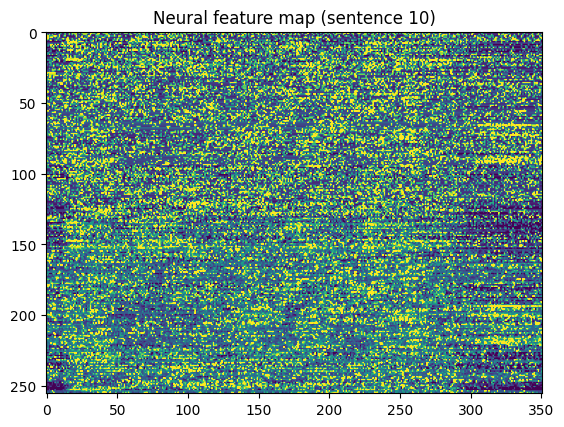

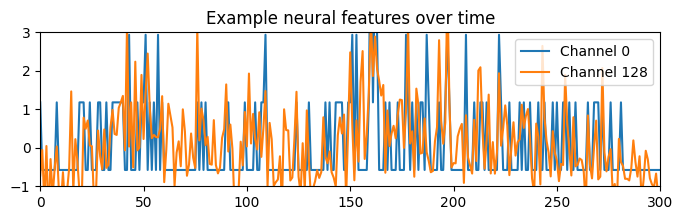

In [21]:
import matplotlib.pyplot as plt

if len(trainDatasets) > 0 and len(trainDatasets[0]['sentenceDat']) > 10:
    plt.figure()
    plt.imshow(trainDatasets[0]['sentenceDat'][10].T, clim=[-1, 1])
    plt.title("Neural feature map (sentence 10)")
    plt.show()

    plt.figure(figsize=(8, 2))
    plt.plot(trainDatasets[0]['sentenceDat'][10][:, 0], label='Channel 0')
    plt.plot(trainDatasets[0]['sentenceDat'][10][:, 128], label='Channel 128')
    plt.title("Example neural features over time")
    plt.xlim([0, 300])
    plt.ylim([-1, 3])
    plt.legend()
    plt.show()
else:
    print("⚠️ Not enough data in trainDatasets[0] to visualize sentence 10.")
